## Initialization

AdaTest requires at least 3 objects to begin testing models:

- **Model**: An NLP model to test (e.g. classifier, translation, generative model, etc.)

- **Generator**: A generative NLP model used to help us probe our model and create tests. 

- **TestTree**: AdaTest's core data structure which stores tests, evaluations, and metadata in a pandas DataFrame-like object.


**Model**: For this example, we'll use a Sequence Classification model from the popular HuggingFace Transformers library (https://huggingface.co/roberta-large-mnli). The task here is to take a pair of sentences and classify them into {'Contradiction', 'Neutral', or 'Entailment'}.

In [1]:
from transformers import pipeline
import adatest

# Initialize sequence classification as a pipeline 
classifier = pipeline("sentiment-analysis", model="roberta-large-mnli", return_all_scores=True)

# Wrap in AdaTest's unified model interface, specifying output names if desired
model = adatest.Model(classifier, output_names = ["CONTRADICTION", "NEUTRAL", "ENTAILMENT"])

# Verify model is loaded correctly
model([r"I like you. </s></s> I hate you."])

array([[9.99470532e-01, 3.55955563e-04, 1.73435867e-04]])

**Generator**: AdaTest supports a variety of generator options, including OpenAI's GPT family of models and models like GPT-Neo in the HuggingFace transformers library. We'll use OpenAI's GPT-3 in this example, but also show how to initialize with other generators.

In [2]:
import os

# NOTE HARSHA: REPLACE THESE
OPENAI_API_KEY = "YOUR_API_KEY_HERE"
gen_model = adatest.generators.OpenAI('curie', api_key=OPENAI_API_KEY)

# Alternatively:
# hf_model = transformers.pipeline('text-generation', model="EleutherAI/gpt-neo-125M")
# gen_model = adatest.generators.Transformers(hf_model.model, hf_model.tokenizer)

**TestTree**: Example TestTrees for many tasks can be downloaded from AdaTest's library here: https://github.com/microsoft/adatest/tree/main/test_trees. You can also build an initial TestTree from a labeled dataset, or simply start one from scratch by constructing from an empty .csv file (which we'll do for this example).

In [3]:
tests = adatest.TestTree(r"sequence_classification_tests.csv")

## AdaTest Interface -- Launch and Walkthrough

We're now ready to launch into the AdaTest interface and begin testing our model by using the TestTree's `adapt` method on our model. We can also wrap this call in `adatest.serve` to create a locally hosted experience that we can launch in our browser for more screen real-estate and working on remote servers. The rest of this notebook will describe the interface in detail and demonstrate how to build a test tree from scratch.

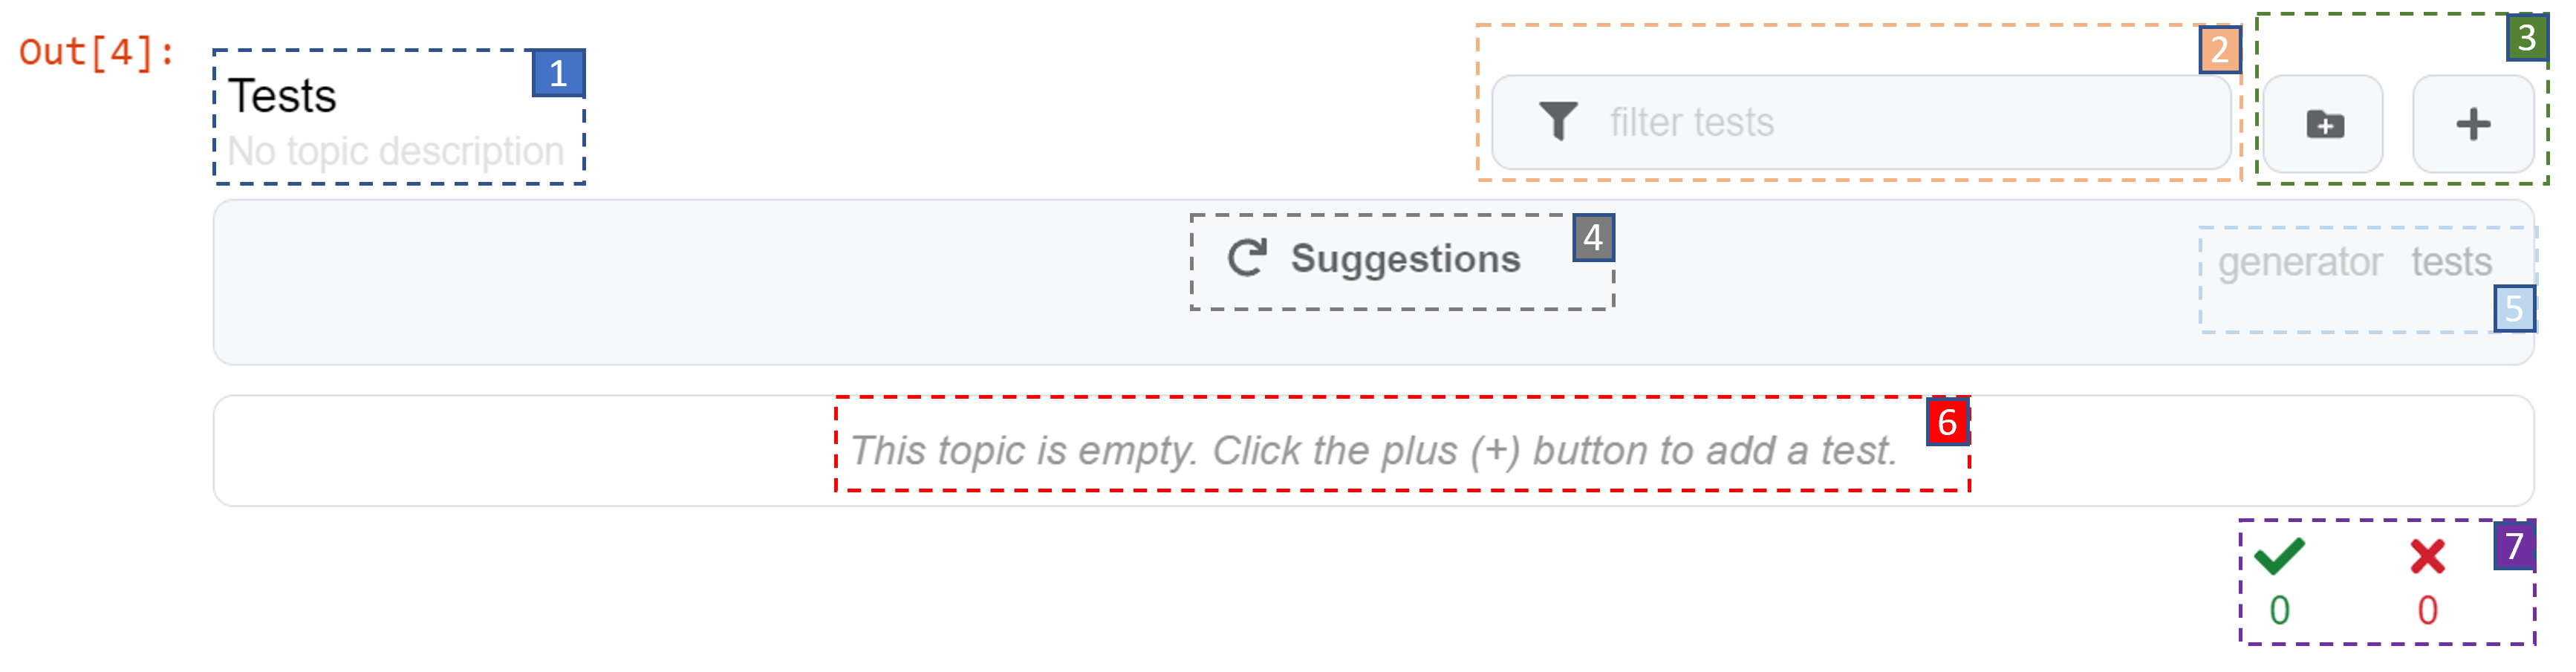

In [4]:
# Launch AdaTest!

tests(
    model,
    generator=gen_model,
    auto_save=True, # Set to "True" to automatically save tests as they are made.
)

# Optionally:
# adatest.serve(tests(model, generator=gen_model, auto_save=True), host='127.0.0.1', port=8080)

We'll begin by describing each major element in the empty interface.

1. Current directory: AdaTest is structured like a file system, with the ability to create multiple folders and sub-folders all stemming from a root "Tests" directory. You can optionally add a description to each folder for extra clarity and organization.

2. Filter box: Filters down any tests or suggestions in view.

3. Manual Creation Buttons: Use these buttons to create a new sub-folder or new test.

4. Suggestions Box: This grey box houses all generated suggestions for new topics or tests. Click the "Suggestions" button at any time to generate new examples if you don't like what you see.

5. Suggestions Options: Specify which generative backend you'd like to use for suggestions, and also change between generating tests and topics.

6. Test Box: Houses all confirmed tests in the Test Tree, filtered down to tests in the current directory and those matching conditions set in the filter box.

7. Aggregated Performance: Shows how many tests are passing or failing for the model at this level of the test tree.

Let's add a new test by clicking the "+" button in box 3 (Manual Creation):

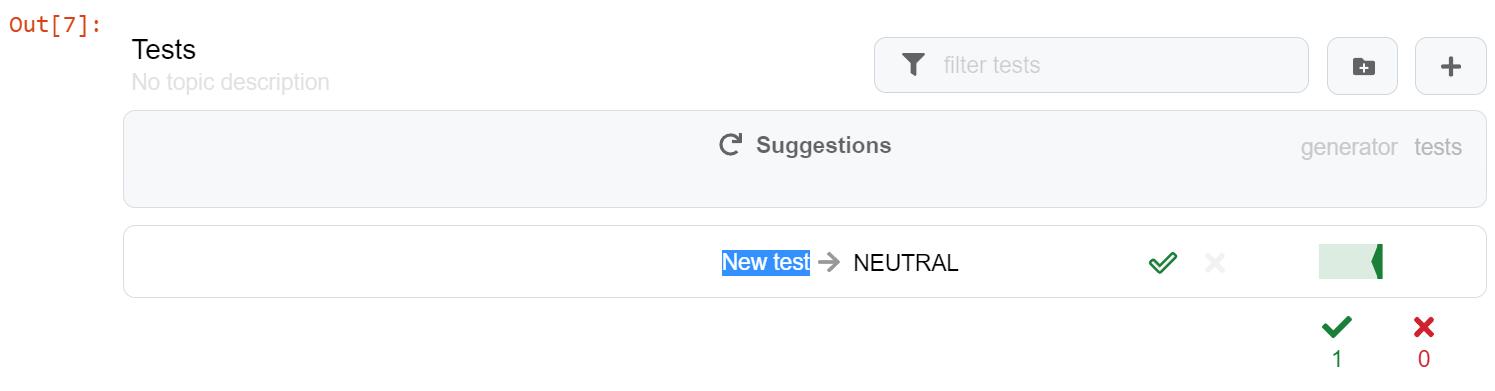

In [5]:
# Add a new test

We're presented with an edit box mapping an input -- by default, the string "New test" -- to the model's actual output ("NEUTRAL"). Let's modify the text box to something the model may realistically expect:

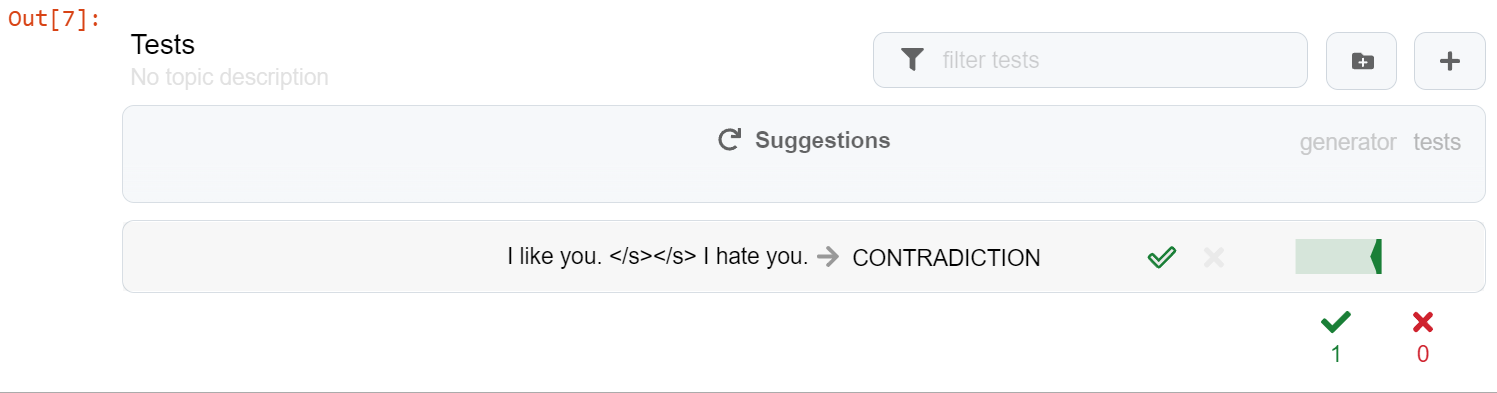

In [6]:
# Modify the test input to a realistic value, in this case: "I like you. </s></s> I hate you."

Now that we've changed the input value, we can see that the new model return type is "CONTRADICTION". Our task is to simply verify if this is correct or incorrect behavior using the ✓ or X buttons. In this case, it seems reasonable so we'll hit "✓", confirming that the model is behaving correctly.

Let's also add a few more similar tests to explore the model space:

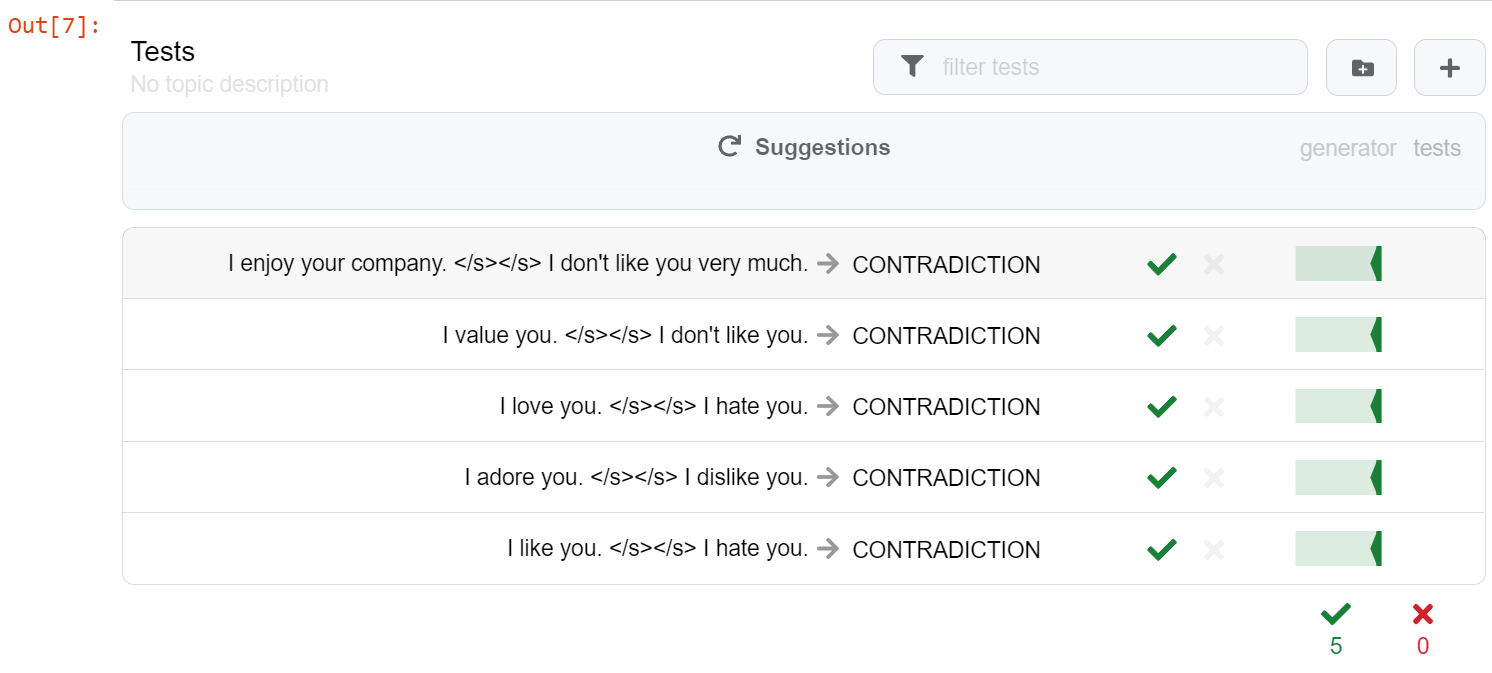

In [7]:
# Add more manual tests

So far, all the tests are passing, which is great -- the model's doing the right thing! However, our goal is to find failures in the model, and we're struggling to do that by manually writing tests. Let's turn to our generative model and ask for test suggestions by hitting the "Suggestions" button:

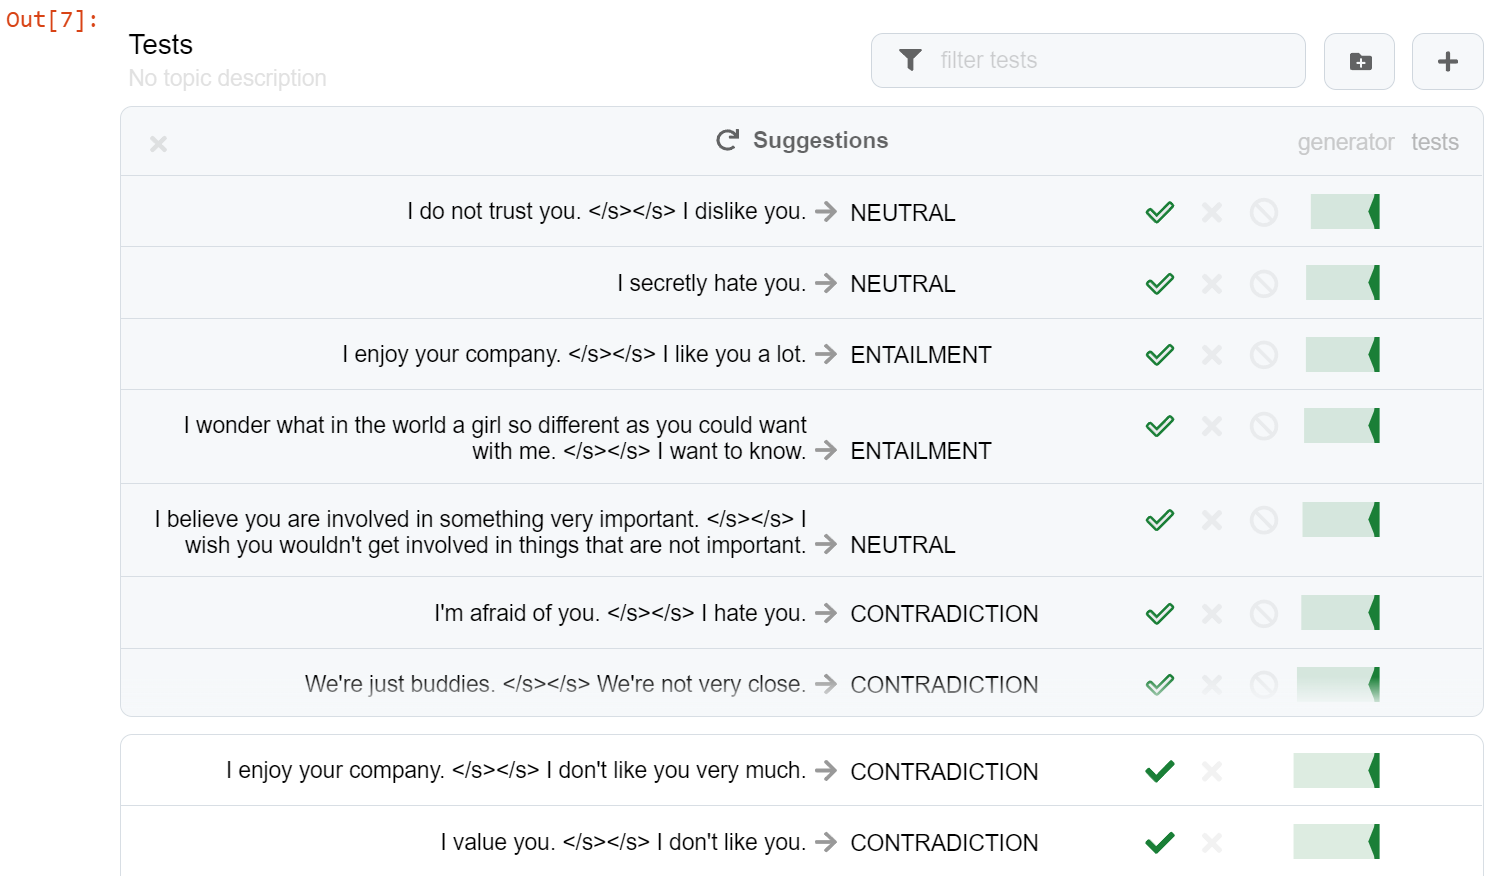

In [8]:
# Generate Suggestions

The generator has created tests that look like the ones we've manually written, and passed them through the model for evaluation. Our job is to inspect these tests and label the ones that exhibit either correct or incorrect behavior. 

Notice that because we've only supplied 5 written examples, the generative model hasn't perfectly learned our input data structure and sometimes suggests malformed tests (e.g. "I secretly hate you."). 

If we're unhappy with the results, we can either regenerate more suggestions or write a few more tests manually to help out the generator. In this case, we may have a few examples worth labeling, including a few failures -- for example, at the bottom: "I'm afraid of you." and "I hate you." are not contradictory! 

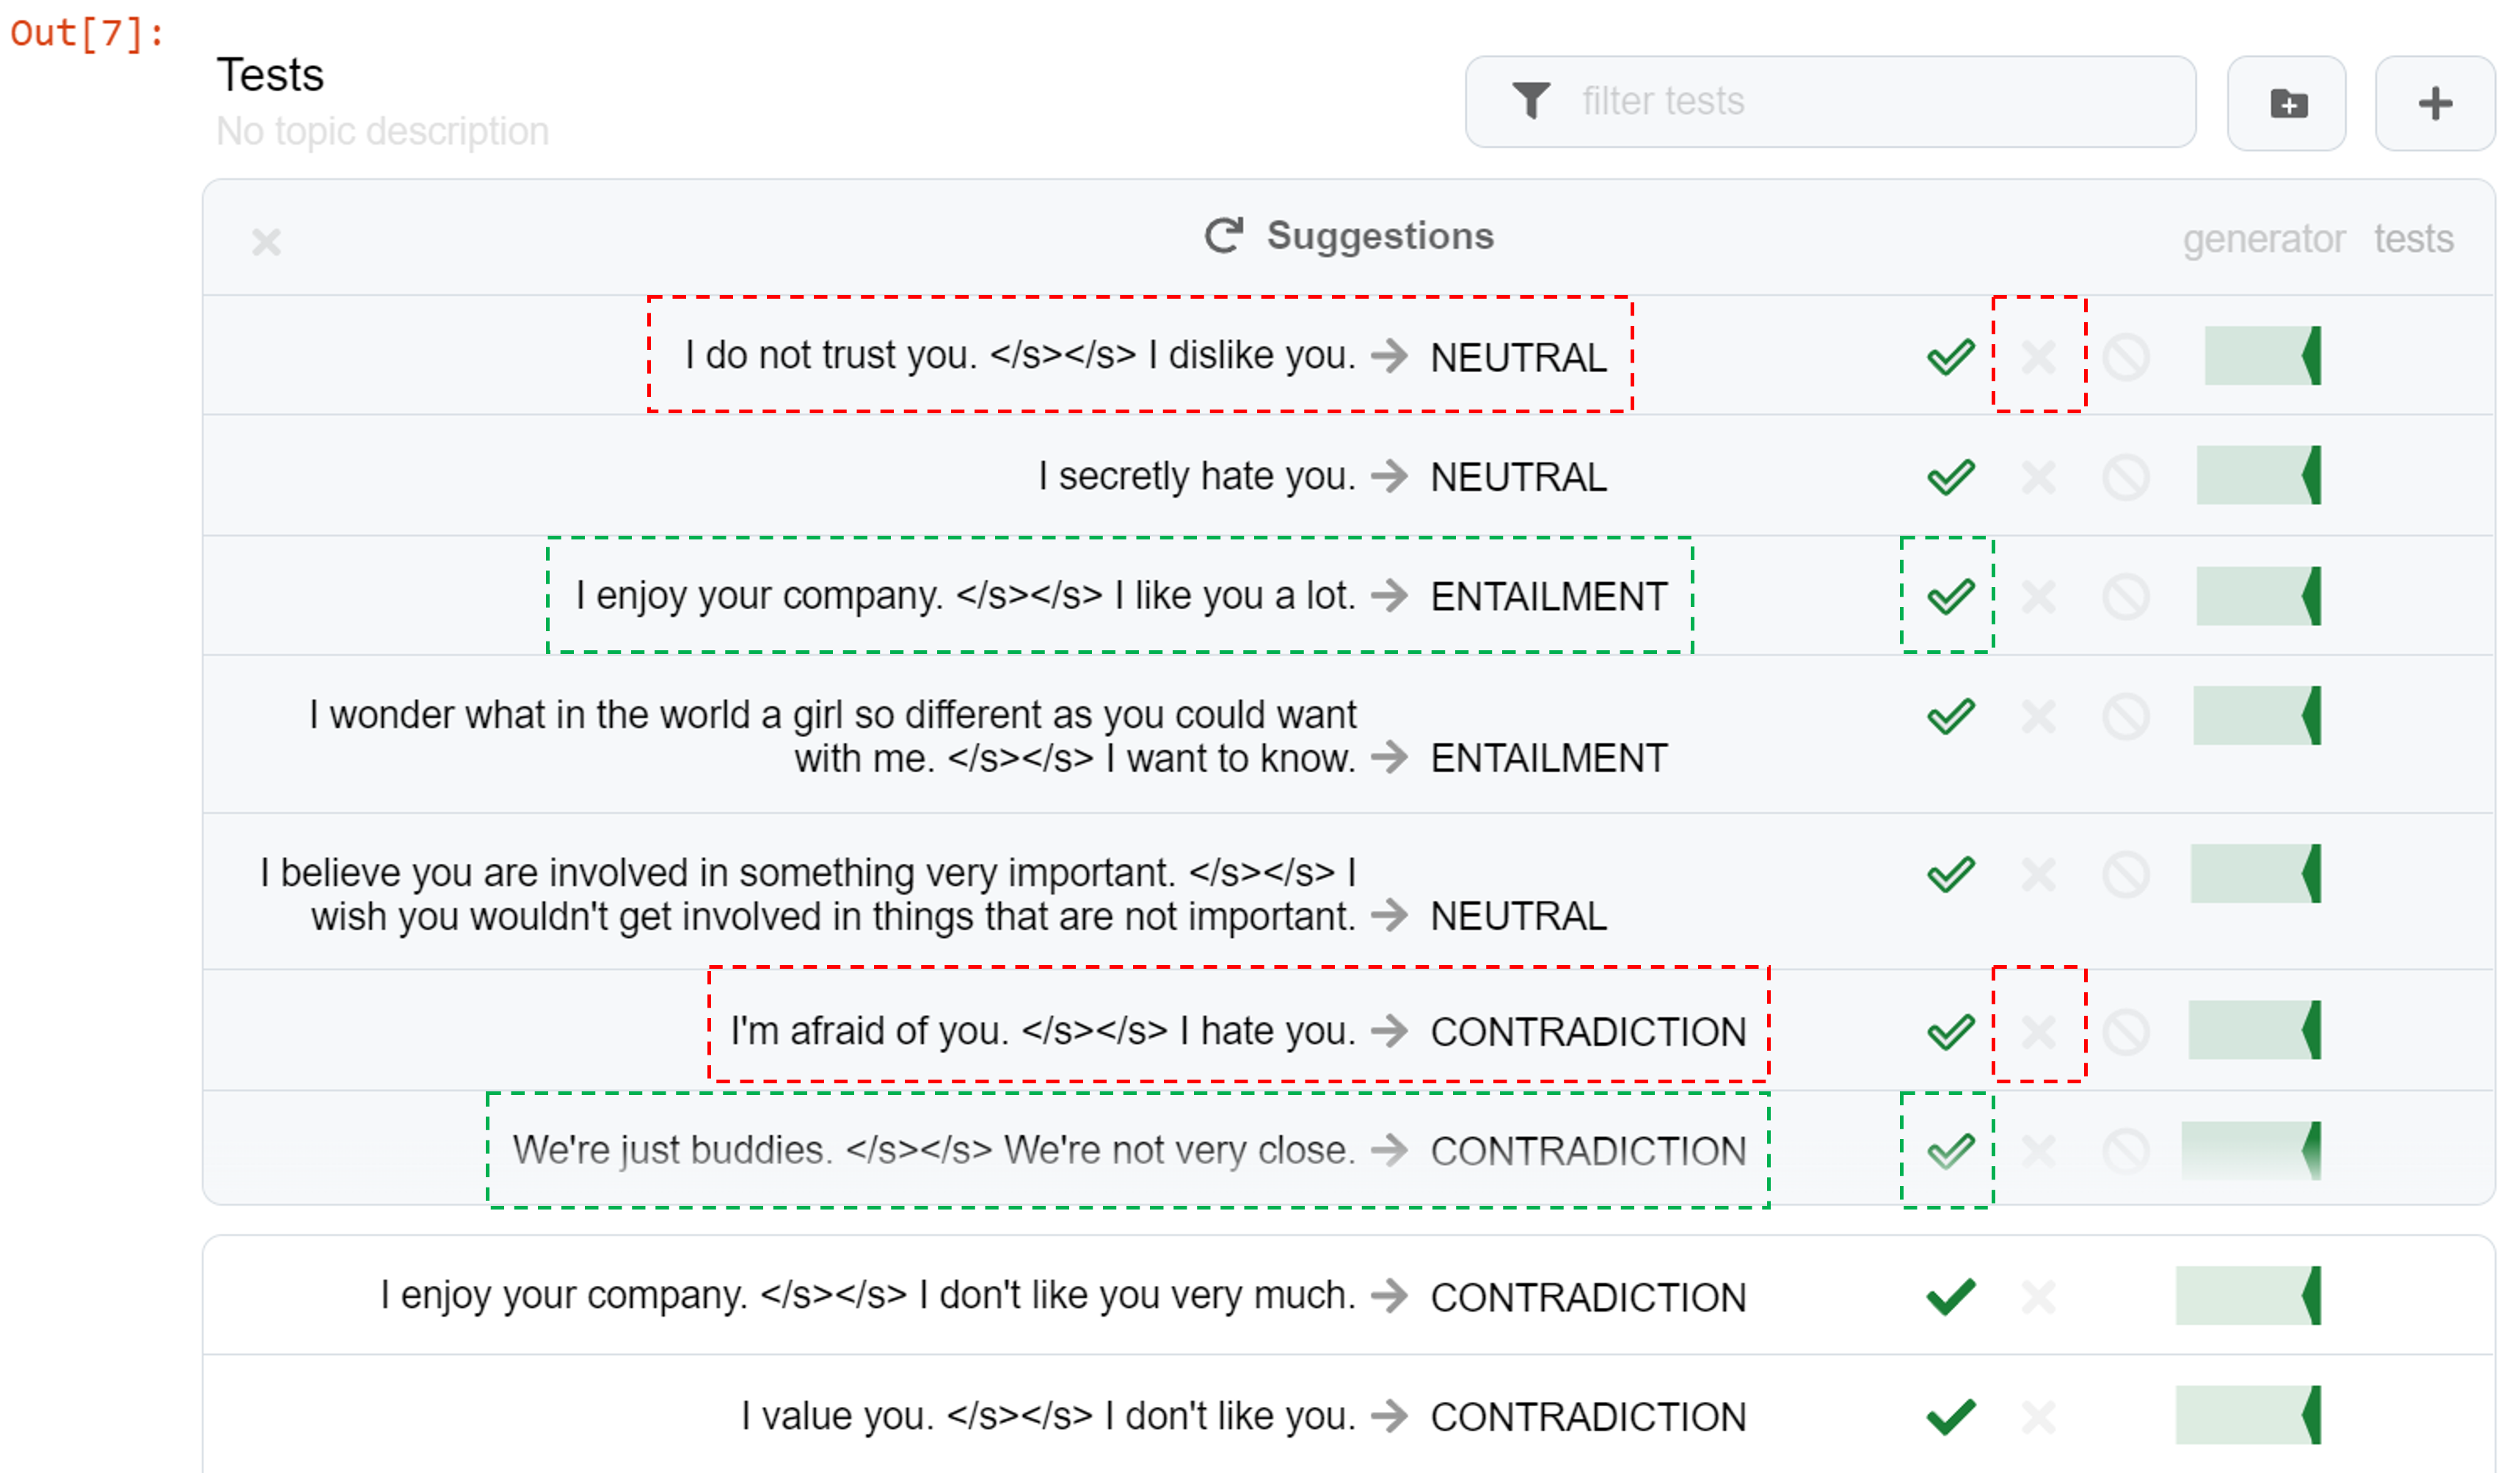

In [9]:
# Label Tests

After we've added several more tests, we can re-generate the suggestions from the generator, which now has more data to understand what type of test structure we expect:

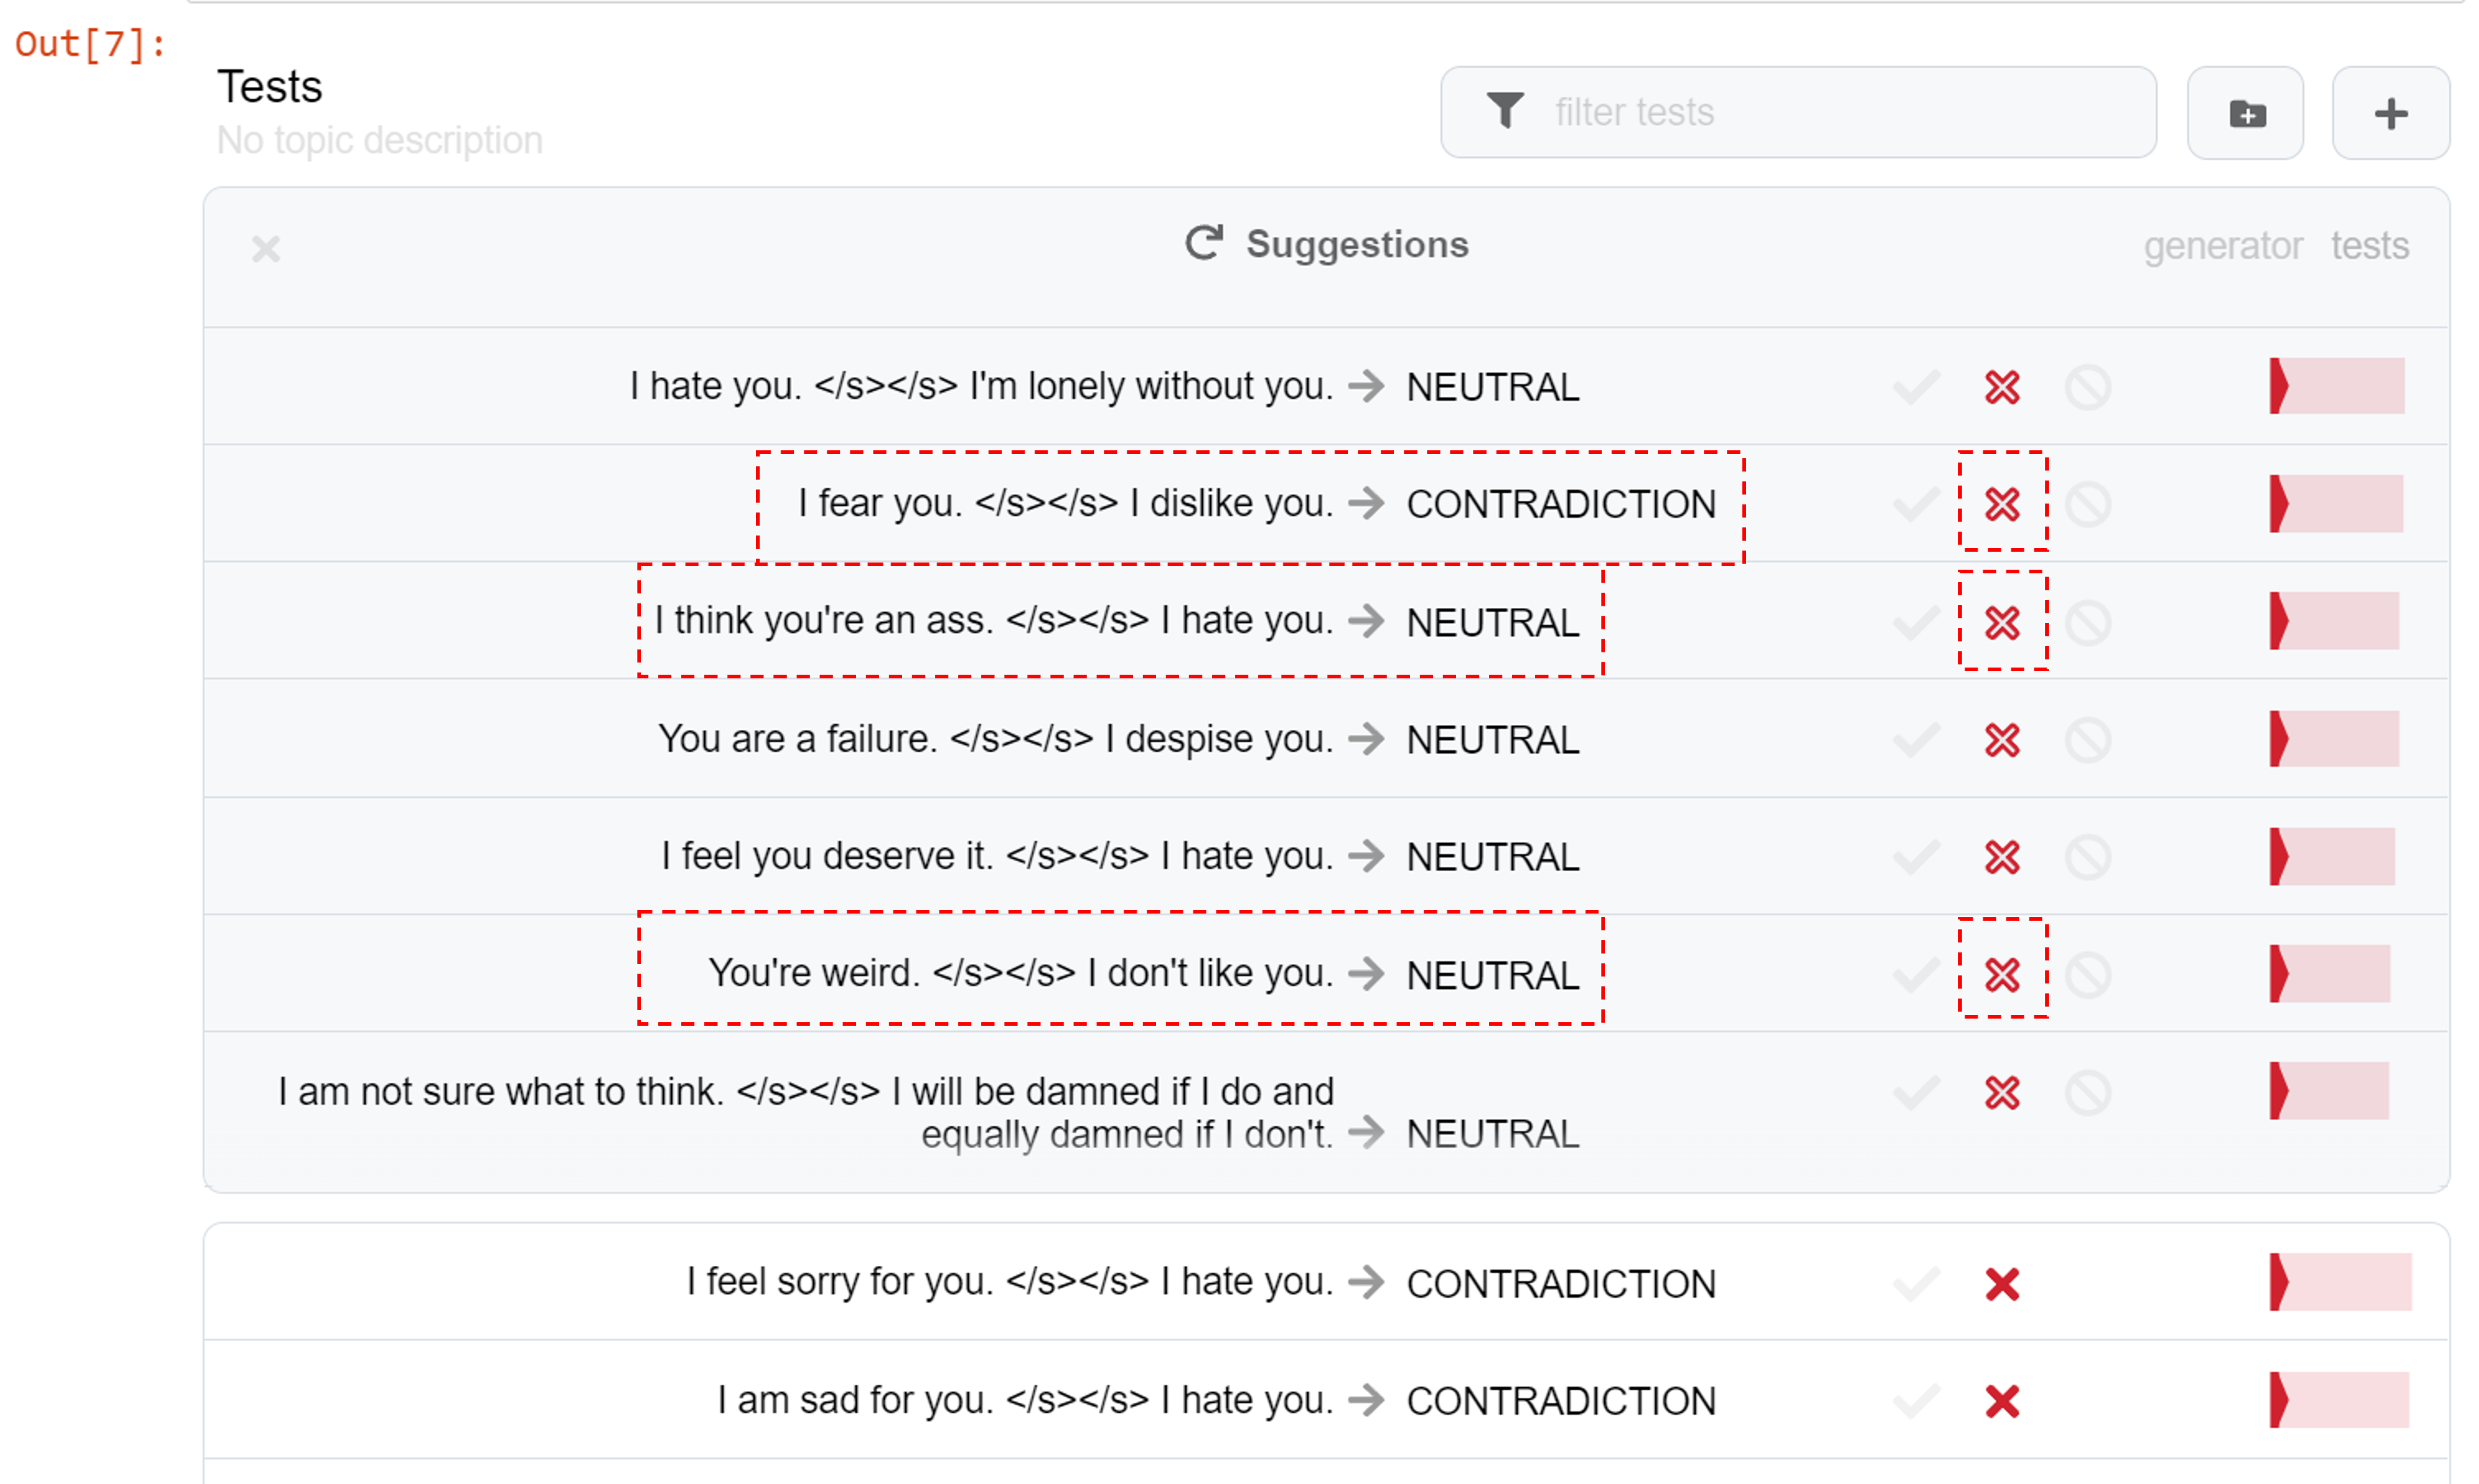

In [10]:
# Re-generate suggestions

This time, every one of the tests is properly structured, and we have several more cases of clear failures (e.g. "I fear you." and "I dislike you" are not contradictory). We can continue this iterative process of labeling a few examples and finding new failures until we're happy we've explored the space!


So far, all of our tests have been testing a very specific aspect of the model: feelings about a single person. We can help AdaTest understand this by grouping all our existing tests into a folder -- simply make a new folder, and drag existing tests into it (you can do multiple tests at once with shift+click).

Another aspect of the model to test might involve sentences that target multiple people, instead of just one person. Let's make a new folder for that too:

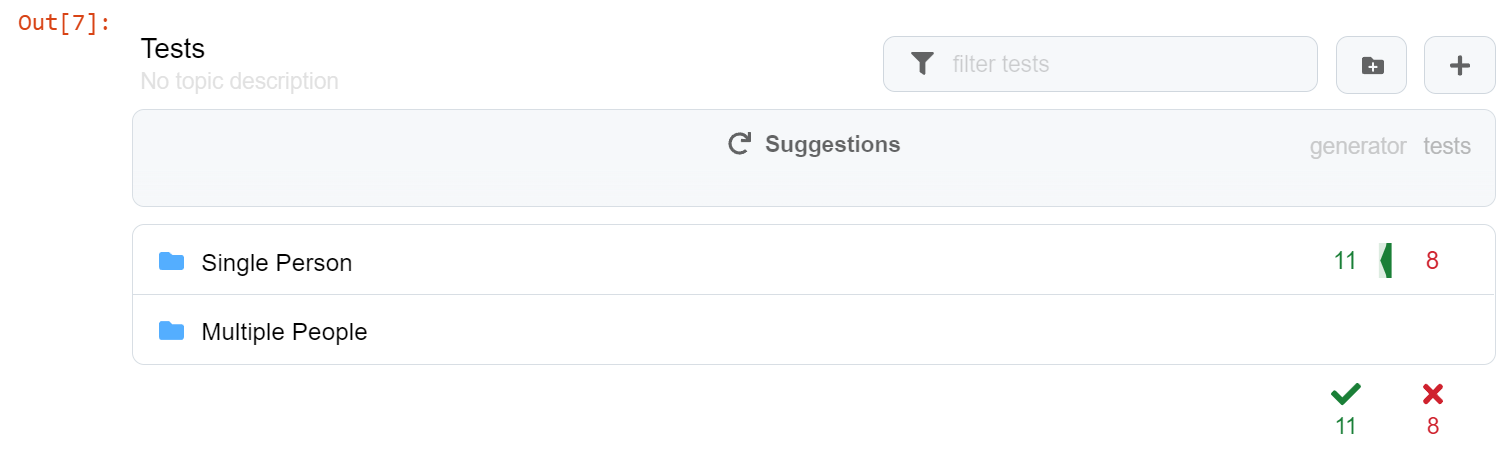

In [11]:
# Add second topic for "Multiple People"

Let's enter into our new folder by clicking into it:

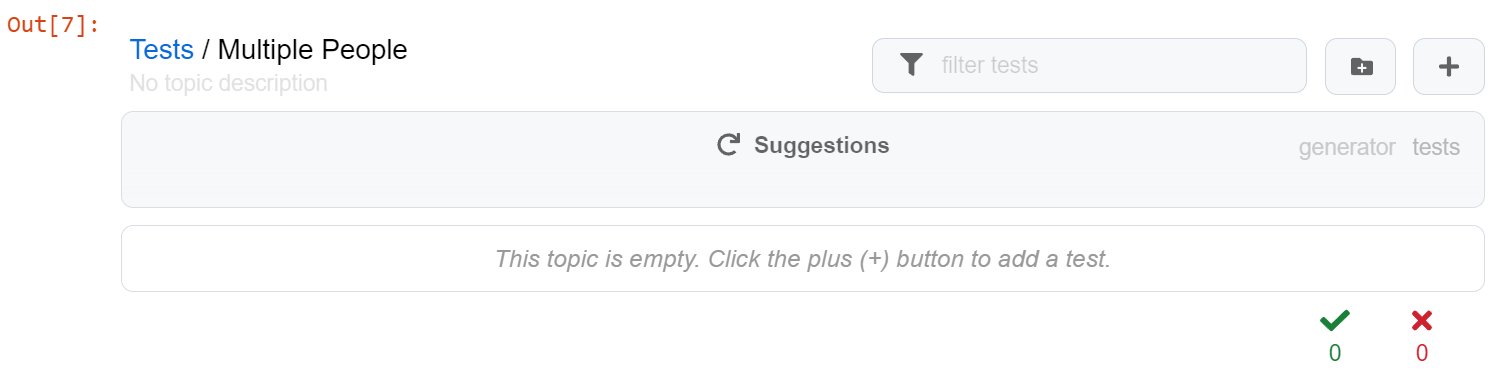

In [12]:
# Enter new topic

The breadcrum in the top left has now updated to show us the current path, and we can now begin writing and generating tests for a different aspect of the model in our new sub folder:

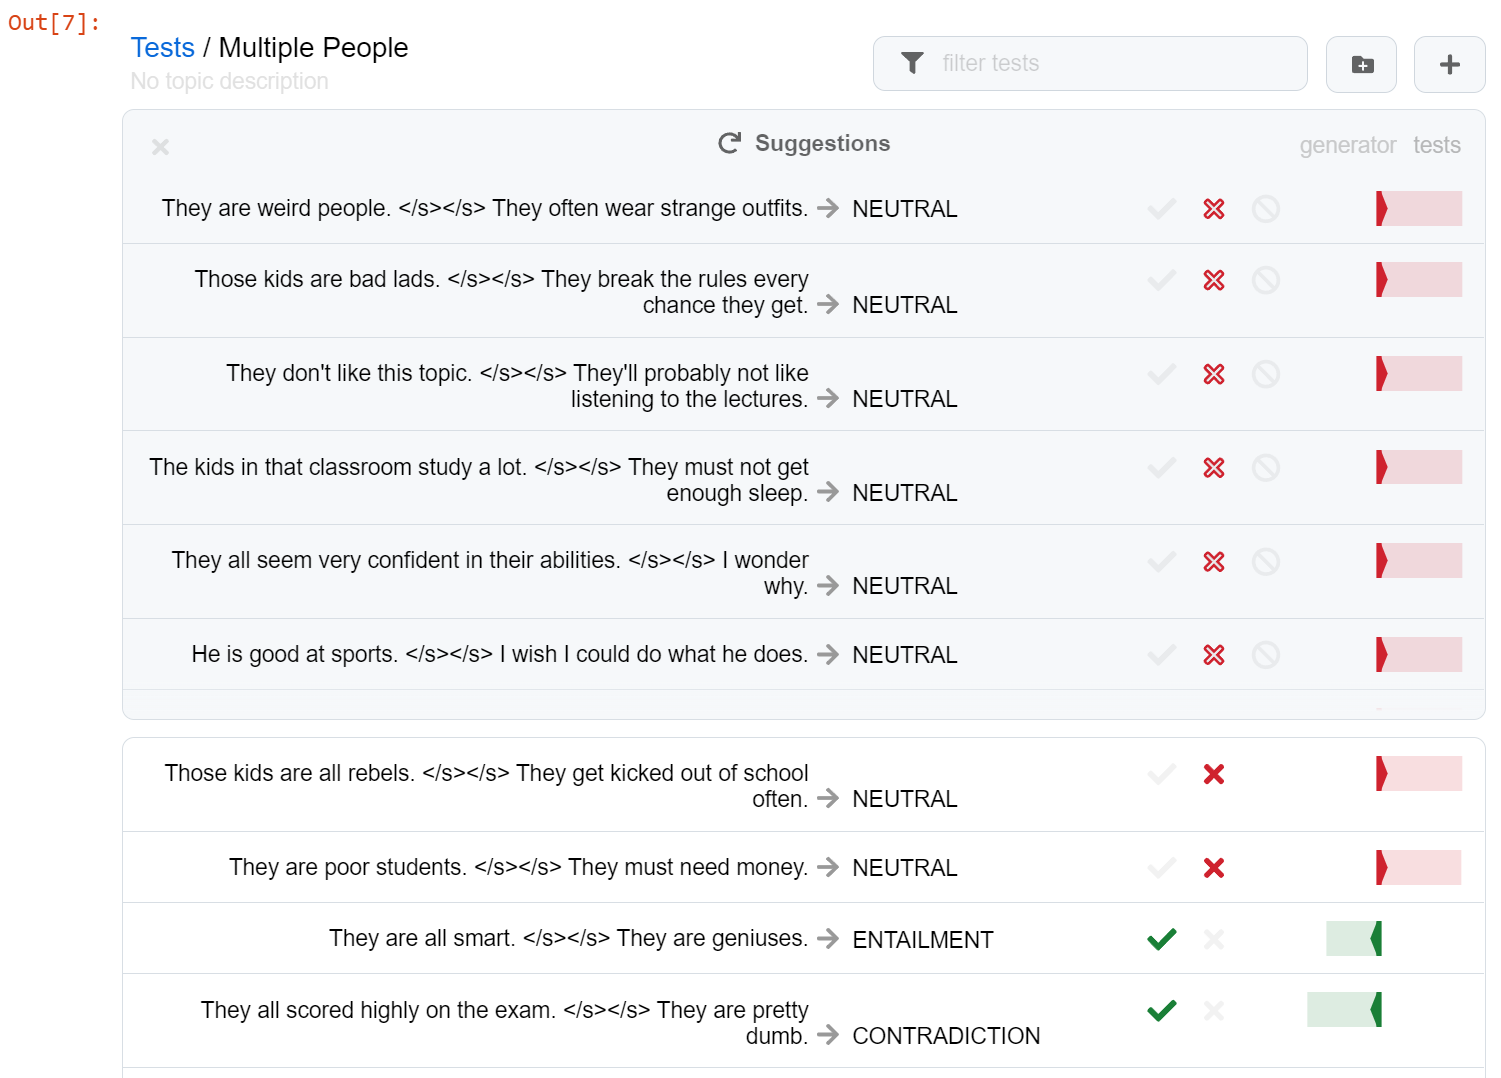

In [13]:
# Begin testing loop inside of new topic

At this point, we can simply repeat the process, having AdaTest help us discover new failure modes and continue to rapidly find failures in our model. Sometimes inspecting the AdaTest outputs will inspire us to create new topics -- maybe there is a theme around "breaking rules" in our examples? 

AdaTest's generator can also suggest new topics for us too via few-shot learning, by simply setting the generation mode to "topics" in the suggestion options interface:

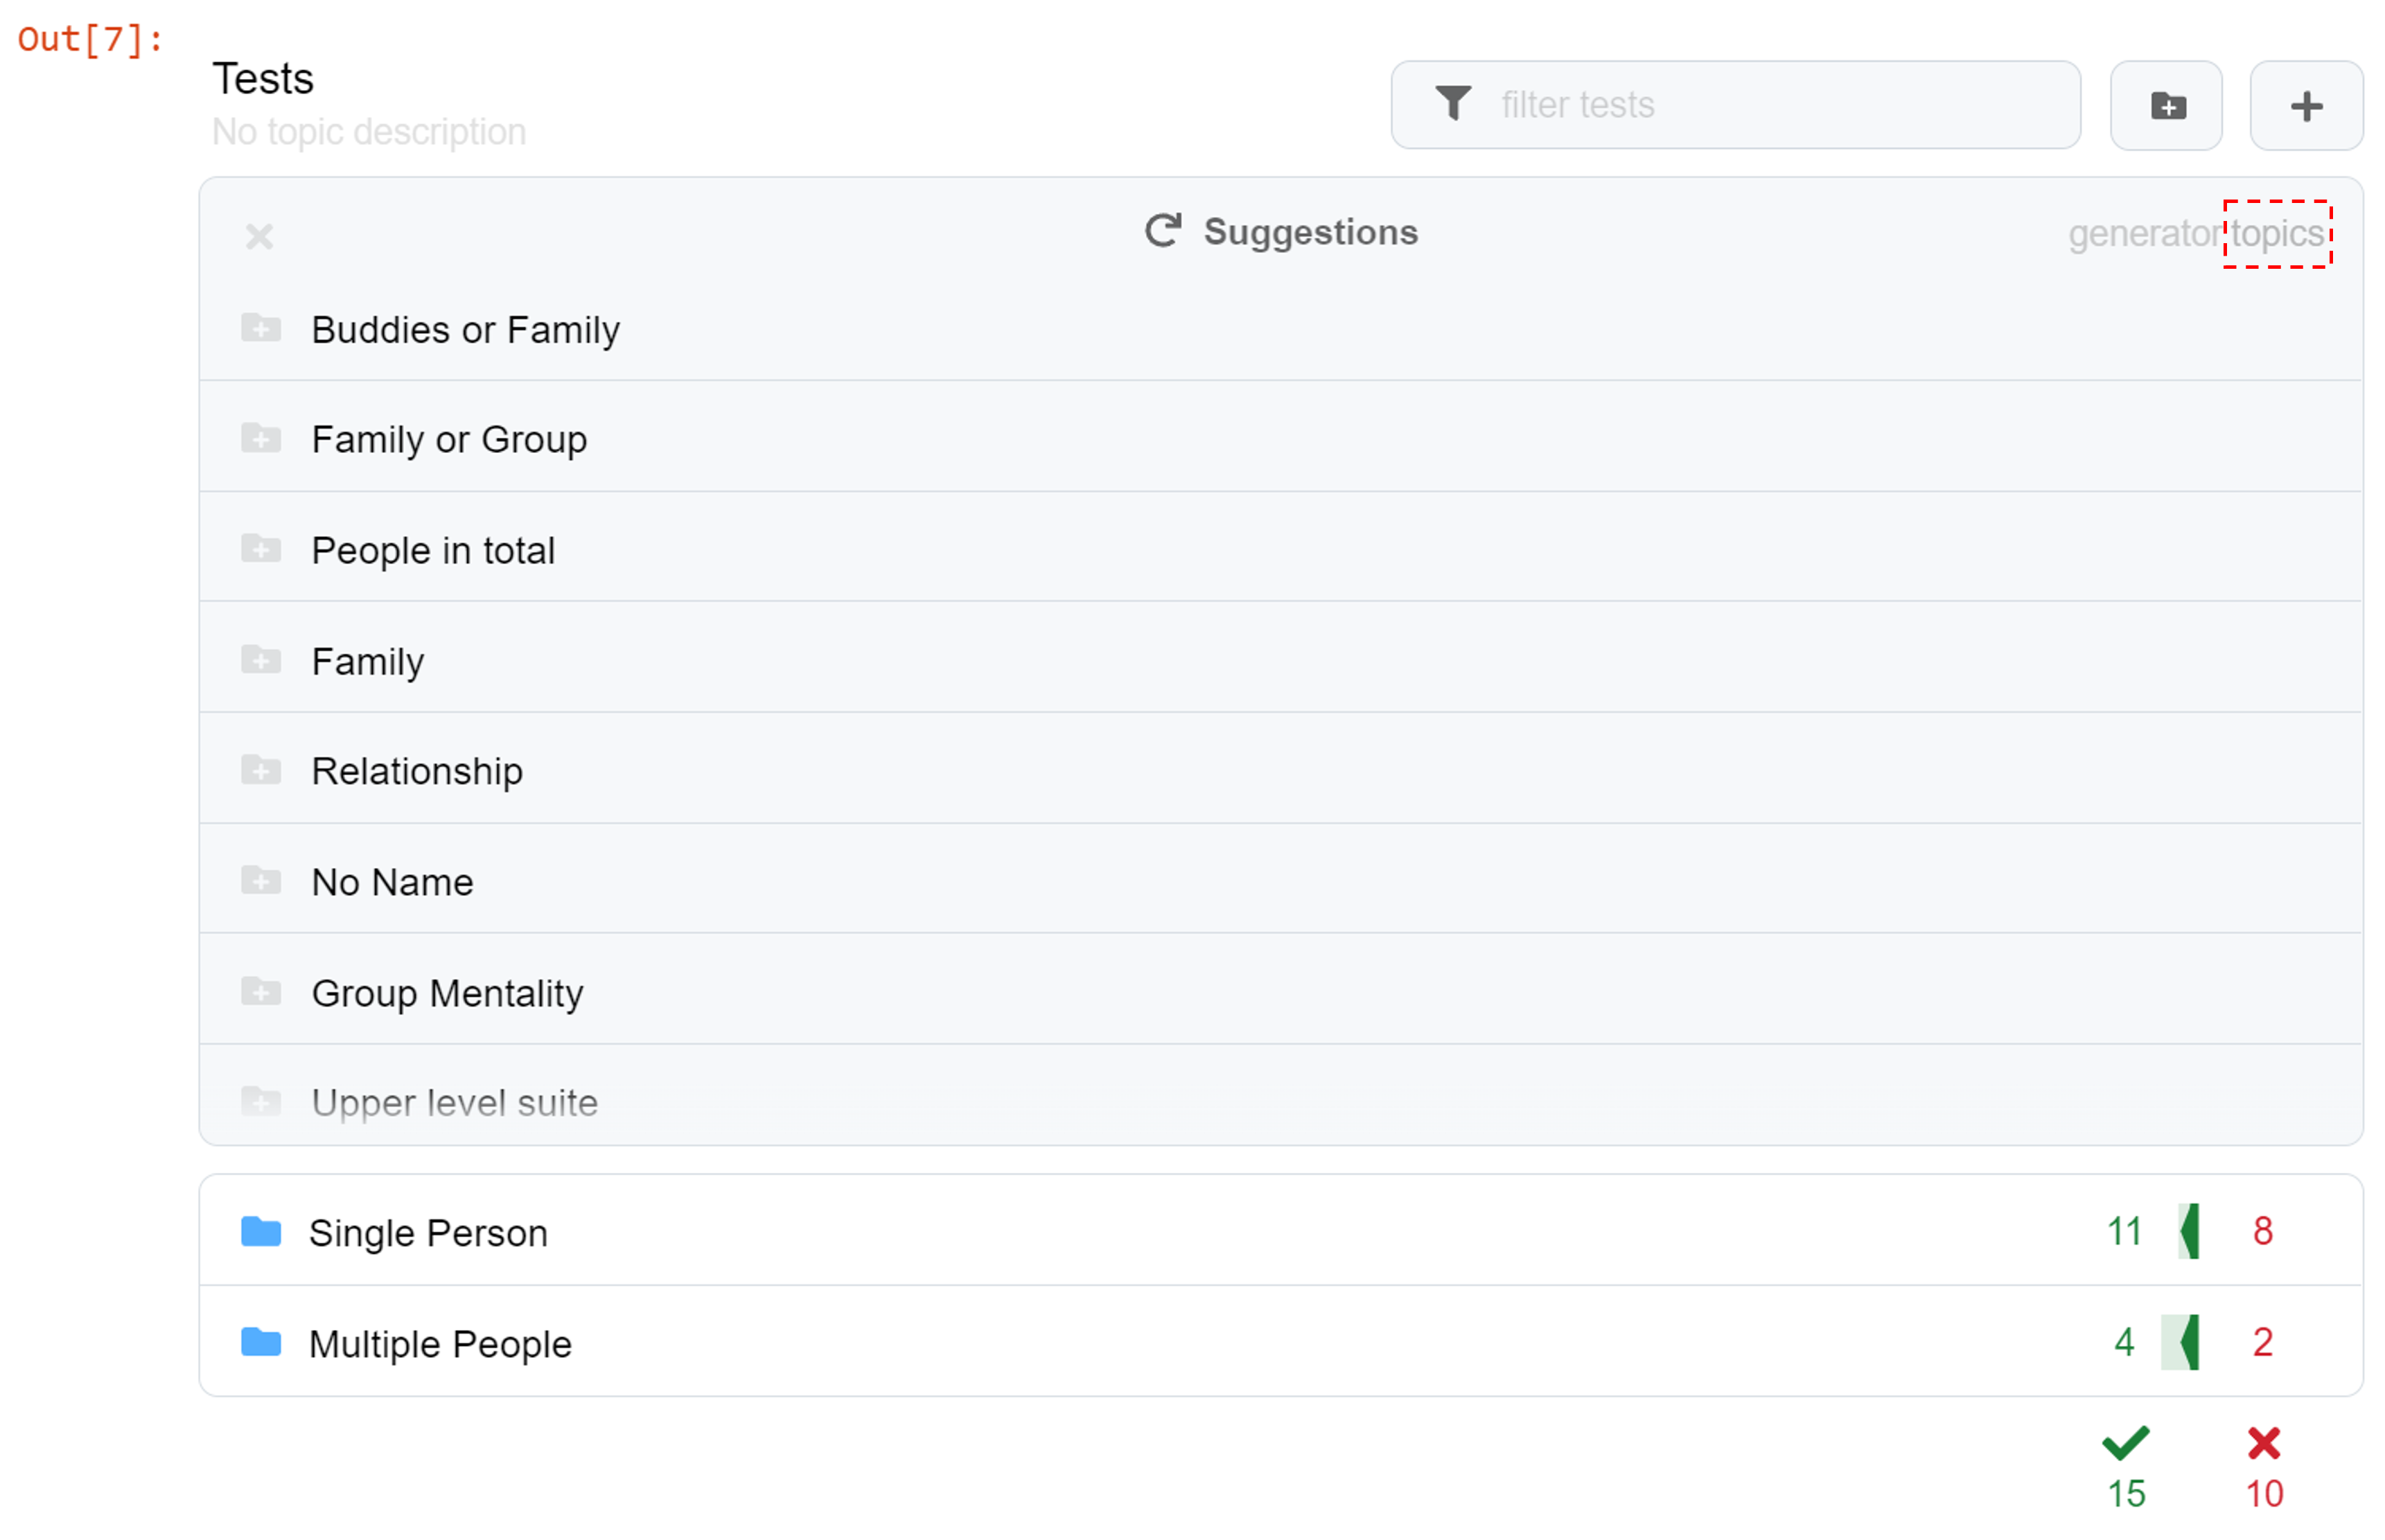

In [14]:
# Generate topic suggestions from root

After adding the "Family" topic, we can enter it and leverage zero-shot learning to generate brand new tests for us without any manually written tests!

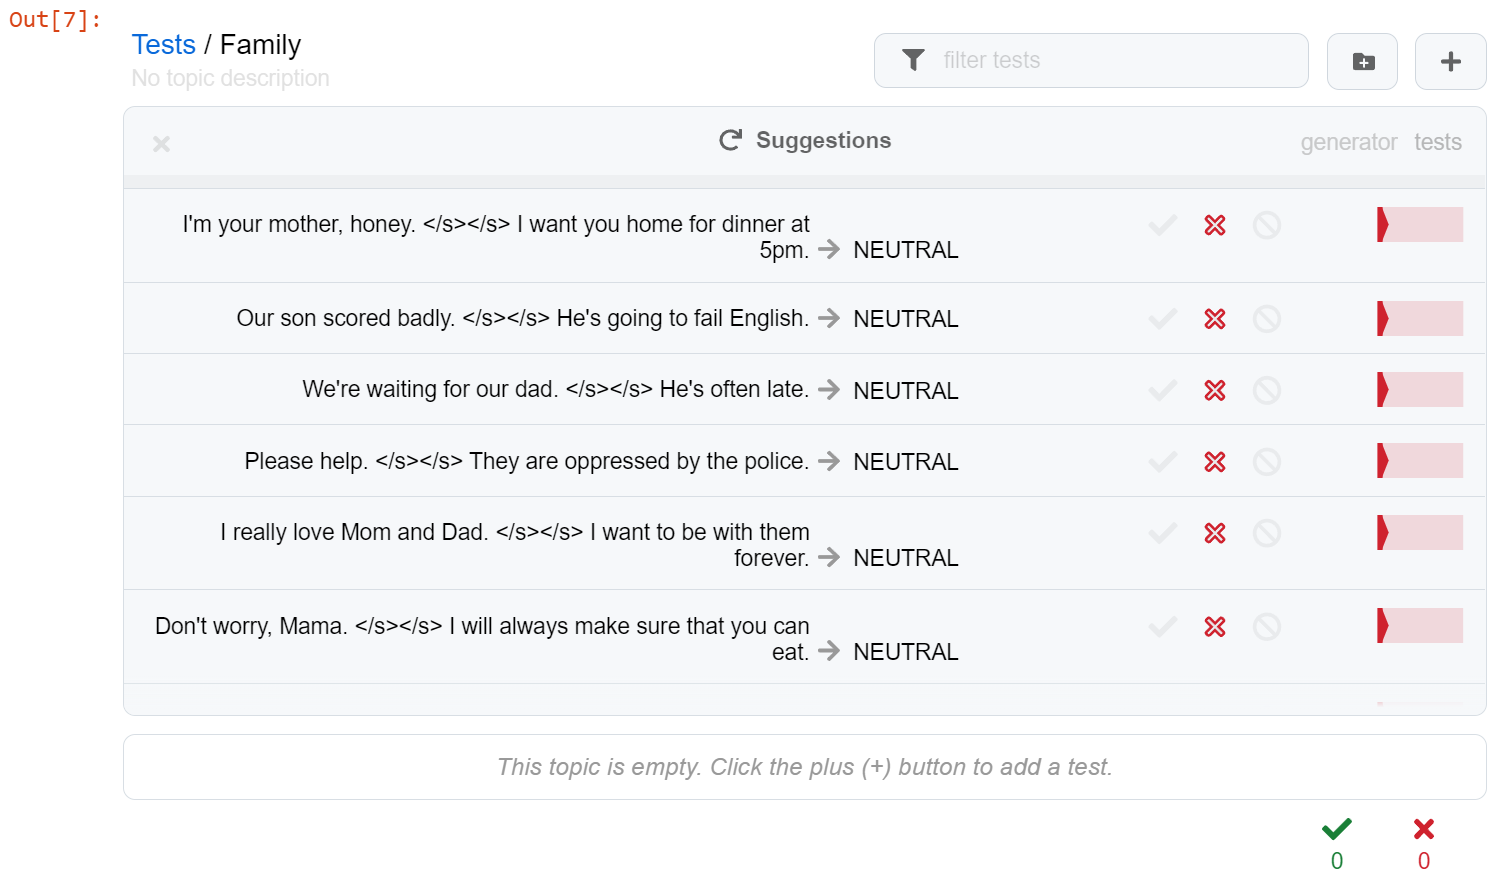

In [15]:
# Zero shot learn tests for "Family" with no manual examples!

Finally, we can repeat this process as much as we'd like to keep rapidly finding new failures and exploring the model's decision space. Once we've collected many errors, we can debug and fix them by fine-tuning our model on these new errors -- see our (upcoming) debugging models notebook for an example of how to do this -- and end up with a hopefully improved model. 

We can then test that new model and begin the process again :).